# Variational Autoencoders in edward2

There is a [script of VAE](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/vae.py) written with tfp, and a [script of grammar VAE](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/grammar_vae.py) written with edward2.


In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
Variable = tf.Variable
import tensorflow_probability as tfp
tfd = tfp.distributions
ed = tfp.edward2
import warnings
warnings.filterwarnings('ignore')

print('TensorFlow version {}, TF Probability version {}.'.format(tf.__version__, tfp.__version__))

TensorFlow version 1.10.0, TF Probability version 0.4.0.


This implementation exploits the Helmholtz energy interpretation of the ELBO.

The ELBO can be rearranged as the sum of the negative energy and entropy of a particle determined by $z$,
where energy is defined as the joint probability $p(x, z)$, which edward2 can conveniently compute with ed.make_log_joint_fn().

In [3]:
xdim, d, zdim = 784, 200, 2
gen_net = tf.keras.Sequential([tf.keras.layers.Dense(d, activation=tf.nn.elu),
                               tf.keras.layers.Dense(d, activation=tf.nn.elu),
                               tf.keras.layers.Dense(xdim, activation=None)])
inference_net = tf.keras.Sequential([tf.keras.layers.Dense(d, activation=tf.nn.elu),
                                     tf.keras.layers.Dense(d, activation=tf.nn.elu),
                                     tf.keras.layers.Dense(2*zdim, activation=None)])

def generative_model(batch_size=None):
    z = ed.MultivariateNormalDiag(loc=tf.zeros([zdim]), scale_identity_multiplier=1.,
                                  sample_shape=batch_size, name='z')
    x = ed.Bernoulli(gen_net(z), name='x')
    return x

def variational_model(x):
    outs = inference_net(x)
    _loc, _scale = outs[:, :zdim], 1e-3 + tf.nn.softplus(outs[:, zdim:])
    z = ed.MultivariateNormalDiag(loc=_loc, scale_diag=_scale, name='z_posterior')
    return z

def get_loss(inputs):
    z = variational_model(inputs)
    energy = log_joint(z=z, x=inputs)
    entropy = tf.reduce_sum(z.distribution.entropy())
    return (-energy - entropy)

def replace_z(z):
    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        name = rv_kwargs.pop('name')
        if name == 'z':
            rv_kwargs['value'] = z
        return rv_constructor(*rv_args, **rv_kwargs)
    return interceptor
    
log_joint = ed.make_log_joint_fn(generative_model)

In [4]:
mnist = tf.keras.datasets.mnist
(x_train, _), _ = mnist.load_data()
x_train = np.rint((x_train / 255.).reshape(-1, xdim)).astype(np.float32)
assert x_train.max() <= 1 and x_train.min() >= 0 #assert correctly

bs = 64
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle((len(x_train)))
dataset = dataset.batch(bs, drop_remainder=True)
dataset = dataset.prefetch(16)
data_iterator = dataset.make_initializable_iterator()
batch_x = data_iterator.get_next()

loss = get_loss(batch_x) / bs  # divide by bs since loss is summed.
opt = tf.contrib.opt.AdamWOptimizer(0, learning_rate=1e-3)
train = opt.minimize(loss)
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
for i in range(50): # 50 epochs; takes <3m on my GPU.
    sess.run(data_iterator.initializer)
    try:
        while True:
            _, _loss = sess.run([train, loss])
    except tf.errors.OutOfRangeError:
        print(_loss, ', end of epoch {}'.format(i))

175.4148 , end of epoch 0
162.85994 , end of epoch 1
162.11514 , end of epoch 2
161.69145 , end of epoch 3
149.25401 , end of epoch 4
148.82094 , end of epoch 5
156.37743 , end of epoch 6
149.35225 , end of epoch 7
145.1838 , end of epoch 8
129.48929 , end of epoch 9
133.09314 , end of epoch 10
138.37376 , end of epoch 11
144.25136 , end of epoch 12
137.37529 , end of epoch 13
146.54836 , end of epoch 14
141.6904 , end of epoch 15
141.78783 , end of epoch 16
138.06657 , end of epoch 17
129.8872 , end of epoch 18
138.07614 , end of epoch 19
138.11337 , end of epoch 20
146.09 , end of epoch 21
152.90785 , end of epoch 22
132.63054 , end of epoch 23
131.18756 , end of epoch 24
127.54576 , end of epoch 25
133.52866 , end of epoch 26
136.73033 , end of epoch 27
132.8782 , end of epoch 28
142.35023 , end of epoch 29
132.41301 , end of epoch 30
139.31429 , end of epoch 31
145.84793 , end of epoch 32
140.5992 , end of epoch 33
143.34369 , end of epoch 34
135.08307 , end of epoch 35
134.11526 ,

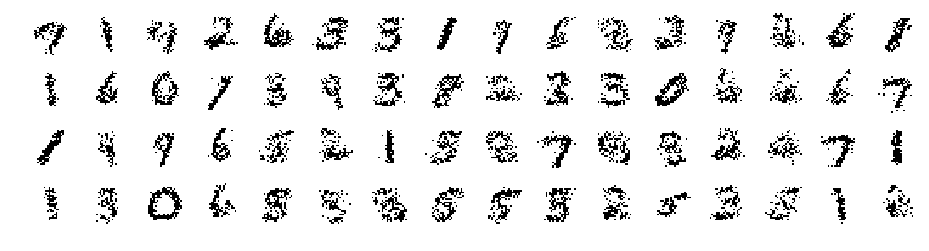

In [5]:
# Generate imgs.
generated = generative_model(batch_size=64)
img = sess.run(generated).reshape(-1, 28, 28)
plt.figure(figsize=(16, 4))
for i in range(64):
    plt.subplot(4, 16, i+1)
    plt.imshow(img[i], cmap='Greys')
    plt.axis('off')
plt.show()

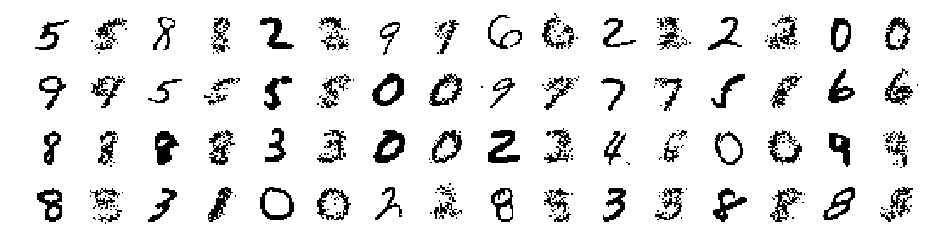

In [6]:
# Reconstruct imgs. Left is original, right is reconstructed.
batch = batch_x
var_z = variational_model(batch)
with ed.interception(replace_z(z=var_z)):
    recon = generative_model()
sess.run(data_iterator.initializer)
_batch, _recon = sess.run([batch, recon])
_batch, _recon = _batch.reshape(-1, 28, 28), _recon.reshape(-1, 28, 28)
plt.figure(figsize=(16, 4))
for i in range(32):
    plt.subplot(4, 16, 2*i+1)
    plt.imshow(_batch[i], cmap='Greys')
    plt.axis('off')
    plt.subplot(4, 16, 2*i+2)
    plt.imshow(_recon[i], cmap='Greys')
    plt.axis('off')
plt.show()

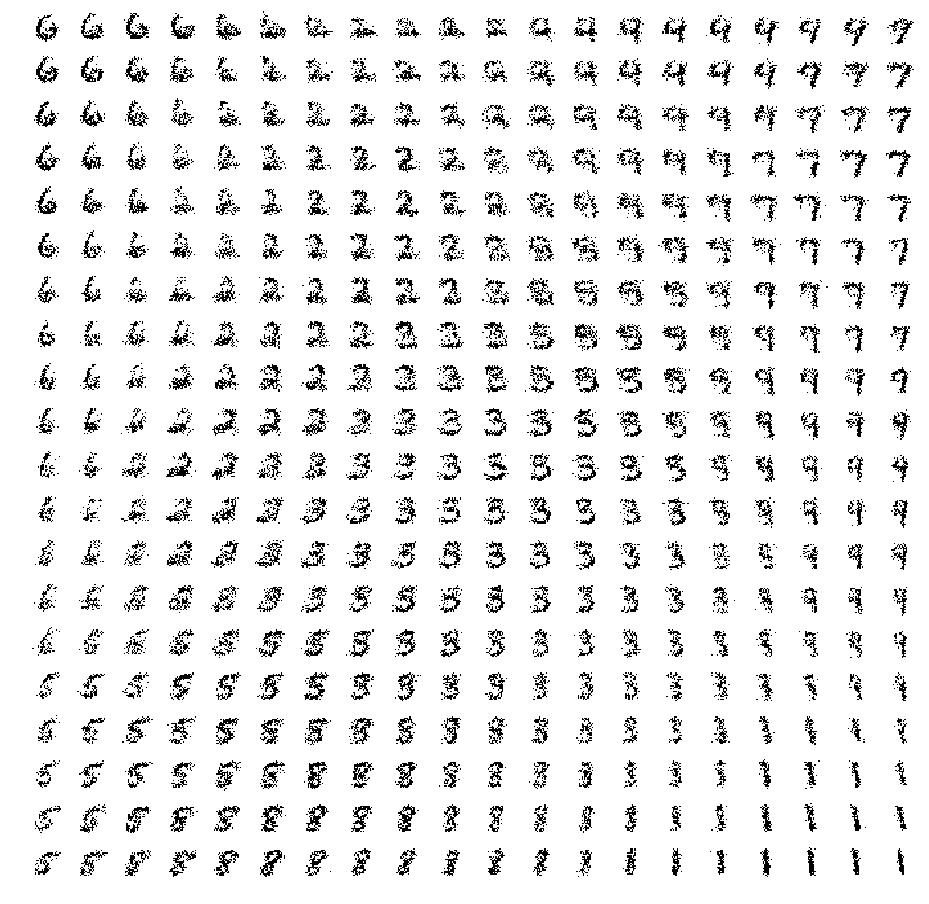

In [7]:
from scipy.stats import norm
N = 20
invcdf = norm.ppf(np.linspace(.1, .9, num=N))
zs = [[invcdf[i], invcdf[j]] for i in range(N) for j in range(N)]
with ed.interception(replace_z(z=zs)):
    recon = generative_model(N*N)
sess.run(data_iterator.initializer)
_recon = sess.run(recon).reshape(-1, 28, 28)
_batch, _recon = _batch.reshape(-1, 28, 28), _recon.reshape(-1, 28, 28)
plt.figure(figsize=(16, 16))
for i in range(N):
    for j in range(N):
        plt.subplot(N, N, N*j+i+1)
        plt.imshow(_recon[N*j+i], cmap='Greys')
        plt.axis('off')
plt.show()